<a href="https://colab.research.google.com/github/hideto7007/python_image-classification/blob/main/image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [3]:


import os
path = "/content/drive/MyDrive/python/deep_learning/PyTorch/models/"

files = os.listdir(path)
files

['vgg16_best_models.pth',
 'resnet_best_models.pth',
 'efficientNet_best_models.pth']

In [4]:
# 乱シード設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benckmark = False

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

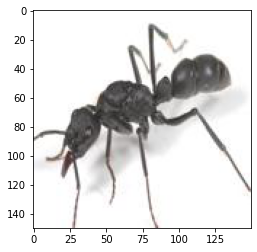

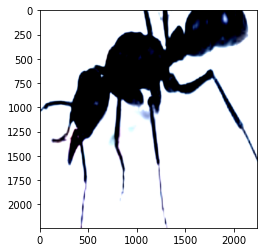

In [47]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

imgae_file_path = 'drive/MyDrive/python/deep_learning/PyTorch/img_data/train/ants/000001_r.jpg'
img = Image.open(imgae_file_path)

plt.imshow(img)
plt.show()

# GPU使う場合
cuda = 1

if cuda == 1:
  size = 2242
else:
  size = 100


mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)



transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [48]:
# アリとハチの画像へのファイルパスのリスト作成する

def make_datapath_list(phase):
    rootpath = "drive/MyDrive/python/deep_learning/PyTorch/img_data/"
    target_path = osp.join(rootpath+phase+'/*/*.jpg')
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

len(train_list)

100

In [49]:
# アリとハチの画像のDatasetを作成する


class HymenopteraDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB') # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[58:62]
        elif self.phase == "val":
            label = img_path[56:60]

        # ラベルを数値に変更する
        if label == "ants":
            label = 0
        elif label == "hati":
            label = 1

        return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
print(len(train_dataset))
# print(val_dataset.__getitem__(index)[0].size())
# print(val_dataset.__getitem__(index)[1])
# train_dataset.__getitem__(index)[0].size()

torch.Size([3, 2242, 2242])
1
100


In [50]:
# ミニバッチのサイズを指定
batch_size = 20

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
print(batch_iterator)
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([20, 3, 2242, 2242])
tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1])


In [51]:
# バッチサイズは全て一律の値でないと、モデル学習時に値が一致してなくエラーとなる
# バッチサイズが一致してるか確認
for i in train_dataloader:
  print(i[1].size())

torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])


In [102]:
# ファインチューニング判別フラグ
fine_flag = 1

# モデル選択
model = "efficientNet"

# 最後の出力層の出力ユニットをアリとハチの2つに付け替える
out_feature = 2

In [103]:
use_pretrained = True  # 学習済みのパラメータを使用

# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []


# ファインチューニングで学習させるパラメータ
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []


if model == "vgg16":
  # VGG-16モデルのインスタンスを生成  
  net = models.vgg16(pretrained=use_pretrained)
  net.classifier[6] = nn.Linear(in_features=4096, out_features=out_feature)
  # パラメータ名
  if fine_flag:
    params_to_update_1 = ["features"]
    params_to_update_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
    params_to_update_3 = ["classifier.6.weight", "classifier.6.bias"]
  else:
    update_param_names = ["classifier.6.weight", "classifier.6.bias"]
  # モデル保存先
  save_path = "/content/drive/MyDrive/python/deep_learning/PyTorch/models/vgg16_best_models_2.pth"
  print(net.classifier)
elif model == "resnet":
  # ResNet50モデルのインスタンスを生成
  net = models.resnet50(pretrained=use_pretrained)
  net.fc = nn.Linear(net.fc.in_features, out_feature)
  # パラメータ名
  if fine_flag:
    params_to_update_1 = ["conv1.weight", "bn1.weight", "bn1.bias"]
    params_to_update_2 = ["layer"]
    params_to_update_3 = ["fc.weight", "fc.bias"]
  else:
    update_param_names = ["fc.weight", "fc.bias"]
  # モデル保存先
  save_path = "/content/drive/MyDrive/python/deep_learning/PyTorch/models/resnet_best_models.pth"
  print(net.fc)
elif model == "efficientNet":
  # EfficientNetモデルのインスタンスを生成
  net = models.efficientnet_b7(pretrained=use_pretrained)
  net.classifier[1] = nn.Linear(in_features=2560, out_features=out_feature, bias=True)
  # パラメータ名
  if fine_flag:
    params_to_update_1 = ["features"]
    params_to_update_2 = ["classifier.1.weight", "classifier.1.bias"]
  else:
    update_param_names = ["classifier.1.weight", "classifier.1.bias"]
  # モデル保存先
  save_path = "/content/drive/MyDrive/python/deep_learning/PyTorch/models/efficientNet_best_models.pth"
  print(net.classifier[1])

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2560, out_features=2, bias=True)
ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [105]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

fine_flag = 1

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
if fine_flag:
  for name, param in net.named_parameters():
    if params_to_update_1[0] in name and (model == "vgg16" or model == "efficientNet"):
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納", name)

    elif name in params_to_update_1 and (model == "resnet"):
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納", name)

    elif name in params_to_update_2 and (model == "vgg16" or model == "efficientNet"):
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納", name)

    elif params_to_update_2[0] in name and (model == "resnet"):
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納", name)

    elif name in params_to_update_3 and (model == "vgg16" or model == "resnet"):
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納", name)
    else:
        param.requires_grad = False

else:
  for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
# print("-----------")
# print(params_to_update)

params_to_update_1に格納 features.0.0.weight
params_to_update_1に格納 features.0.1.weight
params_to_update_1に格納 features.0.1.bias
params_to_update_1に格納 features.1.0.block.0.0.weight
params_to_update_1に格納 features.1.0.block.0.1.weight
params_to_update_1に格納 features.1.0.block.0.1.bias
params_to_update_1に格納 features.1.0.block.1.fc1.weight
params_to_update_1に格納 features.1.0.block.1.fc1.bias
params_to_update_1に格納 features.1.0.block.1.fc2.weight
params_to_update_1に格納 features.1.0.block.1.fc2.bias
params_to_update_1に格納 features.1.0.block.2.0.weight
params_to_update_1に格納 features.1.0.block.2.1.weight
params_to_update_1に格納 features.1.0.block.2.1.bias
params_to_update_1に格納 features.1.1.block.0.0.weight
params_to_update_1に格納 features.1.1.block.0.1.weight
params_to_update_1に格納 features.1.1.block.0.1.bias
params_to_update_1に格納 features.1.1.block.1.fc1.weight
params_to_update_1に格納 features.1.1.block.1.fc1.bias
params_to_update_1に格納 features.1.1.block.1.fc2.weight
params_to_update_1に格納 features.1.1.block.1

[]

```
features.0.weight
features.0.bias
~~~~~
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias
```



```
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer2.1.conv3.weight
layer2.1.bn3.weight
layer2.1.bn3.bias
layer2.2.conv1.weight
layer2.2.bn1.weight
layer2.2.bn1.bias
layer2.2.conv2.weight
layer2.2.bn2.weight
layer2.2.bn2.bias
layer2.2.conv3.weight
layer2.2.bn3.weight
layer2.2.bn3.bias
layer2.3.conv1.weight
layer2.3.bn1.weight
layer2.3.bn1.bias
layer2.3.conv2.weight
layer2.3.bn2.weight
layer2.3.bn2.bias
layer2.3.conv3.weight
layer2.3.bn3.weight
layer2.3.bn3.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.conv3.weight
layer3.0.bn3.weight
layer3.0.bn3.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer3.1.conv3.weight
layer3.1.bn3.weight
layer3.1.bn3.bias
layer3.2.conv1.weight
layer3.2.bn1.weight
layer3.2.bn1.bias
layer3.2.conv2.weight
layer3.2.bn2.weight
layer3.2.bn2.bias
layer3.2.conv3.weight
layer3.2.bn3.weight
layer3.2.bn3.bias
layer3.3.conv1.weight
layer3.3.bn1.weight
layer3.3.bn1.bias
layer3.3.conv2.weight
layer3.3.bn2.weight
layer3.3.bn2.bias
layer3.3.conv3.weight
layer3.3.bn3.weight
layer3.3.bn3.bias
layer3.4.conv1.weight
layer3.4.bn1.weight
layer3.4.bn1.bias
layer3.4.conv2.weight
layer3.4.bn2.weight
layer3.4.bn2.bias
layer3.4.conv3.weight
layer3.4.bn3.weight
layer3.4.bn3.bias
layer3.5.conv1.weight
layer3.5.bn1.weight
layer3.5.bn1.bias
layer3.5.conv2.weight
layer3.5.bn2.weight
layer3.5.bn2.bias
layer3.5.conv3.weight
layer3.5.bn3.weight
layer3.5.bn3.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias
```

```
features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.1.1.block.0.0.weight
features.1.1.block.0.1.weight
features.1.1.block.0.1.bias
features.1.1.block.1.fc1.weight
features.1.1.block.1.fc1.bias
features.1.1.block.1.fc2.weight
features.1.1.block.1.fc2.bias
features.1.1.block.2.0.weight
features.1.1.block.2.1.weight
features.1.1.block.2.1.bias
features.1.2.block.0.0.weight
features.1.2.block.0.1.weight
features.1.2.block.0.1.bias
features.1.2.block.1.fc1.weight
features.1.2.block.1.fc1.bias
features.1.2.block.1.fc2.weight
features.1.2.block.1.fc2.bias
features.1.2.block.2.0.weight
features.1.2.block.2.1.weight
features.1.2.block.2.1.bias
features.1.3.block.0.0.weight
features.1.3.block.0.1.weight
features.1.3.block.0.1.bias
features.1.3.block.1.fc1.weight
features.1.3.block.1.fc1.bias
features.1.3.block.1.fc2.weight
features.1.3.block.1.fc2.bias
features.1.3.block.2.0.weight
features.1.3.block.2.1.weight
features.1.3.block.2.1.bias
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.0.block.2.fc1.weight
features.2.0.block.2.fc1.bias
features.2.0.block.2.fc2.weight
features.2.0.block.2.fc2.bias
features.2.0.block.3.0.weight
features.2.0.block.3.1.weight
features.2.0.block.3.1.bias
features.2.1.block.0.0.weight
features.2.1.block.0.1.weight
features.2.1.block.0.1.bias
features.2.1.block.1.0.weight
features.2.1.block.1.1.weight
features.2.1.block.1.1.bias
features.2.1.block.2.fc1.weight
features.2.1.block.2.fc1.bias
features.2.1.block.2.fc2.weight
features.2.1.block.2.fc2.bias
features.2.1.block.3.0.weight
features.2.1.block.3.1.weight
features.2.1.block.3.1.bias
features.2.2.block.0.0.weight
features.2.2.block.0.1.weight
features.2.2.block.0.1.bias
features.2.2.block.1.0.weight
features.2.2.block.1.1.weight
features.2.2.block.1.1.bias
features.2.2.block.2.fc1.weight
features.2.2.block.2.fc1.bias
features.2.2.block.2.fc2.weight
features.2.2.block.2.fc2.bias
features.2.2.block.3.0.weight
features.2.2.block.3.1.weight
features.2.2.block.3.1.bias
features.2.3.block.0.0.weight
features.2.3.block.0.1.weight
features.2.3.block.0.1.bias
features.2.3.block.1.0.weight
features.2.3.block.1.1.weight
features.2.3.block.1.1.bias
features.2.3.block.2.fc1.weight
features.2.3.block.2.fc1.bias
features.2.3.block.2.fc2.weight
features.2.3.block.2.fc2.bias
features.2.3.block.3.0.weight
features.2.3.block.3.1.weight
features.2.3.block.3.1.bias
features.2.4.block.0.0.weight
features.2.4.block.0.1.weight
features.2.4.block.0.1.bias
features.2.4.block.1.0.weight
features.2.4.block.1.1.weight
features.2.4.block.1.1.bias
features.2.4.block.2.fc1.weight
features.2.4.block.2.fc1.bias
features.2.4.block.2.fc2.weight
features.2.4.block.2.fc2.bias
features.2.4.block.3.0.weight
features.2.4.block.3.1.weight
features.2.4.block.3.1.bias
features.2.5.block.0.0.weight
features.2.5.block.0.1.weight
features.2.5.block.0.1.bias
features.2.5.block.1.0.weight
features.2.5.block.1.1.weight
features.2.5.block.1.1.bias
features.2.5.block.2.fc1.weight
features.2.5.block.2.fc1.bias
features.2.5.block.2.fc2.weight
features.2.5.block.2.fc2.bias
features.2.5.block.3.0.weight
features.2.5.block.3.1.weight
features.2.5.block.3.1.bias
features.2.6.block.0.0.weight
features.2.6.block.0.1.weight
features.2.6.block.0.1.bias
features.2.6.block.1.0.weight
features.2.6.block.1.1.weight
features.2.6.block.1.1.bias
features.2.6.block.2.fc1.weight
features.2.6.block.2.fc1.bias
features.2.6.block.2.fc2.weight
features.2.6.block.2.fc2.bias
features.2.6.block.3.0.weight
features.2.6.block.3.1.weight
features.2.6.block.3.1.bias
features.3.0.block.0.0.weight
features.3.0.block.0.1.weight
features.3.0.block.0.1.bias
features.3.0.block.1.0.weight
features.3.0.block.1.1.weight
features.3.0.block.1.1.bias
features.3.0.block.2.fc1.weight
features.3.0.block.2.fc1.bias
features.3.0.block.2.fc2.weight
features.3.0.block.2.fc2.bias
features.3.0.block.3.0.weight
features.3.0.block.3.1.weight
features.3.0.block.3.1.bias
features.3.1.block.0.0.weight
features.3.1.block.0.1.weight
features.3.1.block.0.1.bias
features.3.1.block.1.0.weight
features.3.1.block.1.1.weight
features.3.1.block.1.1.bias
features.3.1.block.2.fc1.weight
features.3.1.block.2.fc1.bias
features.3.1.block.2.fc2.weight
features.3.1.block.2.fc2.bias
features.3.1.block.3.0.weight
features.3.1.block.3.1.weight
features.3.1.block.3.1.bias
features.3.2.block.0.0.weight
features.3.2.block.0.1.weight
features.3.2.block.0.1.bias
features.3.2.block.1.0.weight
features.3.2.block.1.1.weight
features.3.2.block.1.1.bias
features.3.2.block.2.fc1.weight
features.3.2.block.2.fc1.bias
features.3.2.block.2.fc2.weight
features.3.2.block.2.fc2.bias
features.3.2.block.3.0.weight
features.3.2.block.3.1.weight
features.3.2.block.3.1.bias
features.3.3.block.0.0.weight
features.3.3.block.0.1.weight
features.3.3.block.0.1.bias
features.3.3.block.1.0.weight
features.3.3.block.1.1.weight
features.3.3.block.1.1.bias
features.3.3.block.2.fc1.weight
features.3.3.block.2.fc1.bias
features.3.3.block.2.fc2.weight
features.3.3.block.2.fc2.bias
features.3.3.block.3.0.weight
features.3.3.block.3.1.weight
features.3.3.block.3.1.bias
features.3.4.block.0.0.weight
features.3.4.block.0.1.weight
features.3.4.block.0.1.bias
features.3.4.block.1.0.weight
features.3.4.block.1.1.weight
features.3.4.block.1.1.bias
features.3.4.block.2.fc1.weight
features.3.4.block.2.fc1.bias
features.3.4.block.2.fc2.weight
features.3.4.block.2.fc2.bias
features.3.4.block.3.0.weight
features.3.4.block.3.1.weight
features.3.4.block.3.1.bias
features.3.5.block.0.0.weight
features.3.5.block.0.1.weight
features.3.5.block.0.1.bias
features.3.5.block.1.0.weight
features.3.5.block.1.1.weight
features.3.5.block.1.1.bias
features.3.5.block.2.fc1.weight
features.3.5.block.2.fc1.bias
features.3.5.block.2.fc2.weight
features.3.5.block.2.fc2.bias
features.3.5.block.3.0.weight
features.3.5.block.3.1.weight
features.3.5.block.3.1.bias
features.3.6.block.0.0.weight
features.3.6.block.0.1.weight
features.3.6.block.0.1.bias
features.3.6.block.1.0.weight
features.3.6.block.1.1.weight
features.3.6.block.1.1.bias
features.3.6.block.2.fc1.weight
features.3.6.block.2.fc1.bias
features.3.6.block.2.fc2.weight
features.3.6.block.2.fc2.bias
features.3.6.block.3.0.weight
features.3.6.block.3.1.weight
features.3.6.block.3.1.bias
features.4.0.block.0.0.weight
features.4.0.block.0.1.weight
features.4.0.block.0.1.bias
features.4.0.block.1.0.weight
features.4.0.block.1.1.weight
features.4.0.block.1.1.bias
features.4.0.block.2.fc1.weight
features.4.0.block.2.fc1.bias
features.4.0.block.2.fc2.weight
features.4.0.block.2.fc2.bias
features.4.0.block.3.0.weight
features.4.0.block.3.1.weight
features.4.0.block.3.1.bias
features.4.1.block.0.0.weight
features.4.1.block.0.1.weight
features.4.1.block.0.1.bias
features.4.1.block.1.0.weight
features.4.1.block.1.1.weight
features.4.1.block.1.1.bias
features.4.1.block.2.fc1.weight
features.4.1.block.2.fc1.bias
features.4.1.block.2.fc2.weight
features.4.1.block.2.fc2.bias
features.4.1.block.3.0.weight
features.4.1.block.3.1.weight
features.4.1.block.3.1.bias
features.4.2.block.0.0.weight
features.4.2.block.0.1.weight
features.4.2.block.0.1.bias
features.4.2.block.1.0.weight
features.4.2.block.1.1.weight
features.4.2.block.1.1.bias
features.4.2.block.2.fc1.weight
features.4.2.block.2.fc1.bias
features.4.2.block.2.fc2.weight
features.4.2.block.2.fc2.bias
features.4.2.block.3.0.weight
features.4.2.block.3.1.weight
features.4.2.block.3.1.bias
features.4.3.block.0.0.weight
features.4.3.block.0.1.weight
features.4.3.block.0.1.bias
features.4.3.block.1.0.weight
features.4.3.block.1.1.weight
features.4.3.block.1.1.bias
features.4.3.block.2.fc1.weight
features.4.3.block.2.fc1.bias
features.4.3.block.2.fc2.weight
features.4.3.block.2.fc2.bias
features.4.3.block.3.0.weight
features.4.3.block.3.1.weight
features.4.3.block.3.1.bias
features.4.4.block.0.0.weight
features.4.4.block.0.1.weight
features.4.4.block.0.1.bias
features.4.4.block.1.0.weight
features.4.4.block.1.1.weight
features.4.4.block.1.1.bias
features.4.4.block.2.fc1.weight
features.4.4.block.2.fc1.bias
features.4.4.block.2.fc2.weight
features.4.4.block.2.fc2.bias
features.4.4.block.3.0.weight
features.4.4.block.3.1.weight
features.4.4.block.3.1.bias
features.4.5.block.0.0.weight
features.4.5.block.0.1.weight
features.4.5.block.0.1.bias
features.4.5.block.1.0.weight
features.4.5.block.1.1.weight
features.4.5.block.1.1.bias
features.4.5.block.2.fc1.weight
features.4.5.block.2.fc1.bias
features.4.5.block.2.fc2.weight
features.4.5.block.2.fc2.bias
features.4.5.block.3.0.weight
features.4.5.block.3.1.weight
features.4.5.block.3.1.bias
features.4.6.block.0.0.weight
features.4.6.block.0.1.weight
features.4.6.block.0.1.bias
features.4.6.block.1.0.weight
features.4.6.block.1.1.weight
features.4.6.block.1.1.bias
features.4.6.block.2.fc1.weight
features.4.6.block.2.fc1.bias
features.4.6.block.2.fc2.weight
features.4.6.block.2.fc2.bias
features.4.6.block.3.0.weight
features.4.6.block.3.1.weight
features.4.6.block.3.1.bias
features.4.7.block.0.0.weight
features.4.7.block.0.1.weight
features.4.7.block.0.1.bias
features.4.7.block.1.0.weight
features.4.7.block.1.1.weight
features.4.7.block.1.1.bias
features.4.7.block.2.fc1.weight
features.4.7.block.2.fc1.bias
features.4.7.block.2.fc2.weight
features.4.7.block.2.fc2.bias
features.4.7.block.3.0.weight
features.4.7.block.3.1.weight
features.4.7.block.3.1.bias
features.4.8.block.0.0.weight
features.4.8.block.0.1.weight
features.4.8.block.0.1.bias
features.4.8.block.1.0.weight
features.4.8.block.1.1.weight
features.4.8.block.1.1.bias
features.4.8.block.2.fc1.weight
features.4.8.block.2.fc1.bias
features.4.8.block.2.fc2.weight
features.4.8.block.2.fc2.bias
features.4.8.block.3.0.weight
features.4.8.block.3.1.weight
features.4.8.block.3.1.bias
features.4.9.block.0.0.weight
features.4.9.block.0.1.weight
features.4.9.block.0.1.bias
features.4.9.block.1.0.weight
features.4.9.block.1.1.weight
features.4.9.block.1.1.bias
features.4.9.block.2.fc1.weight
features.4.9.block.2.fc1.bias
features.4.9.block.2.fc2.weight
features.4.9.block.2.fc2.bias
features.4.9.block.3.0.weight
features.4.9.block.3.1.weight
features.4.9.block.3.1.bias
features.5.0.block.0.0.weight
features.5.0.block.0.1.weight
features.5.0.block.0.1.bias
features.5.0.block.1.0.weight
features.5.0.block.1.1.weight
features.5.0.block.1.1.bias
features.5.0.block.2.fc1.weight
features.5.0.block.2.fc1.bias
features.5.0.block.2.fc2.weight
features.5.0.block.2.fc2.bias
features.5.0.block.3.0.weight
features.5.0.block.3.1.weight
features.5.0.block.3.1.bias
features.5.1.block.0.0.weight
features.5.1.block.0.1.weight
features.5.1.block.0.1.bias
features.5.1.block.1.0.weight
features.5.1.block.1.1.weight
features.5.1.block.1.1.bias
features.5.1.block.2.fc1.weight
features.5.1.block.2.fc1.bias
features.5.1.block.2.fc2.weight
features.5.1.block.2.fc2.bias
features.5.1.block.3.0.weight
features.5.1.block.3.1.weight
features.5.1.block.3.1.bias
features.5.2.block.0.0.weight
features.5.2.block.0.1.weight
features.5.2.block.0.1.bias
features.5.2.block.1.0.weight
features.5.2.block.1.1.weight
features.5.2.block.1.1.bias
features.5.2.block.2.fc1.weight
features.5.2.block.2.fc1.bias
features.5.2.block.2.fc2.weight
features.5.2.block.2.fc2.bias
features.5.2.block.3.0.weight
features.5.2.block.3.1.weight
features.5.2.block.3.1.bias
features.5.3.block.0.0.weight
features.5.3.block.0.1.weight
features.5.3.block.0.1.bias
features.5.3.block.1.0.weight
features.5.3.block.1.1.weight
features.5.3.block.1.1.bias
features.5.3.block.2.fc1.weight
features.5.3.block.2.fc1.bias
features.5.3.block.2.fc2.weight
features.5.3.block.2.fc2.bias
features.5.3.block.3.0.weight
features.5.3.block.3.1.weight
features.5.3.block.3.1.bias
features.5.4.block.0.0.weight
features.5.4.block.0.1.weight
features.5.4.block.0.1.bias
features.5.4.block.1.0.weight
features.5.4.block.1.1.weight
features.5.4.block.1.1.bias
features.5.4.block.2.fc1.weight
features.5.4.block.2.fc1.bias
features.5.4.block.2.fc2.weight
features.5.4.block.2.fc2.bias
features.5.4.block.3.0.weight
features.5.4.block.3.1.weight
features.5.4.block.3.1.bias
features.5.5.block.0.0.weight
features.5.5.block.0.1.weight
features.5.5.block.0.1.bias
features.5.5.block.1.0.weight
features.5.5.block.1.1.weight
features.5.5.block.1.1.bias
features.5.5.block.2.fc1.weight
features.5.5.block.2.fc1.bias
features.5.5.block.2.fc2.weight
features.5.5.block.2.fc2.bias
features.5.5.block.3.0.weight
features.5.5.block.3.1.weight
features.5.5.block.3.1.bias
features.5.6.block.0.0.weight
features.5.6.block.0.1.weight
features.5.6.block.0.1.bias
features.5.6.block.1.0.weight
features.5.6.block.1.1.weight
features.5.6.block.1.1.bias
features.5.6.block.2.fc1.weight
features.5.6.block.2.fc1.bias
features.5.6.block.2.fc2.weight
features.5.6.block.2.fc2.bias
features.5.6.block.3.0.weight
features.5.6.block.3.1.weight
features.5.6.block.3.1.bias
features.5.7.block.0.0.weight
features.5.7.block.0.1.weight
features.5.7.block.0.1.bias
features.5.7.block.1.0.weight
features.5.7.block.1.1.weight
features.5.7.block.1.1.bias
features.5.7.block.2.fc1.weight
features.5.7.block.2.fc1.bias
features.5.7.block.2.fc2.weight
features.5.7.block.2.fc2.bias
features.5.7.block.3.0.weight
features.5.7.block.3.1.weight
features.5.7.block.3.1.bias
features.5.8.block.0.0.weight
features.5.8.block.0.1.weight
features.5.8.block.0.1.bias
features.5.8.block.1.0.weight
features.5.8.block.1.1.weight
features.5.8.block.1.1.bias
features.5.8.block.2.fc1.weight
features.5.8.block.2.fc1.bias
features.5.8.block.2.fc2.weight
features.5.8.block.2.fc2.bias
features.5.8.block.3.0.weight
features.5.8.block.3.1.weight
features.5.8.block.3.1.bias
features.5.9.block.0.0.weight
features.5.9.block.0.1.weight
features.5.9.block.0.1.bias
features.5.9.block.1.0.weight
features.5.9.block.1.1.weight
features.5.9.block.1.1.bias
features.5.9.block.2.fc1.weight
features.5.9.block.2.fc1.bias
features.5.9.block.2.fc2.weight
features.5.9.block.2.fc2.bias
features.5.9.block.3.0.weight
features.5.9.block.3.1.weight
features.5.9.block.3.1.bias
features.6.0.block.0.0.weight
features.6.0.block.0.1.weight
features.6.0.block.0.1.bias
features.6.0.block.1.0.weight
features.6.0.block.1.1.weight
features.6.0.block.1.1.bias
features.6.0.block.2.fc1.weight
features.6.0.block.2.fc1.bias
features.6.0.block.2.fc2.weight
features.6.0.block.2.fc2.bias
features.6.0.block.3.0.weight
features.6.0.block.3.1.weight
features.6.0.block.3.1.bias
features.6.1.block.0.0.weight
features.6.1.block.0.1.weight
features.6.1.block.0.1.bias
features.6.1.block.1.0.weight
features.6.1.block.1.1.weight
features.6.1.block.1.1.bias
features.6.1.block.2.fc1.weight
features.6.1.block.2.fc1.bias
features.6.1.block.2.fc2.weight
features.6.1.block.2.fc2.bias
features.6.1.block.3.0.weight
features.6.1.block.3.1.weight
features.6.1.block.3.1.bias
features.6.2.block.0.0.weight
features.6.2.block.0.1.weight
features.6.2.block.0.1.bias
features.6.2.block.1.0.weight
features.6.2.block.1.1.weight
features.6.2.block.1.1.bias
features.6.2.block.2.fc1.weight
features.6.2.block.2.fc1.bias
features.6.2.block.2.fc2.weight
features.6.2.block.2.fc2.bias
features.6.2.block.3.0.weight
features.6.2.block.3.1.weight
features.6.2.block.3.1.bias
features.6.3.block.0.0.weight
features.6.3.block.0.1.weight
features.6.3.block.0.1.bias
features.6.3.block.1.0.weight
features.6.3.block.1.1.weight
features.6.3.block.1.1.bias
features.6.3.block.2.fc1.weight
features.6.3.block.2.fc1.bias
features.6.3.block.2.fc2.weight
features.6.3.block.2.fc2.bias
features.6.3.block.3.0.weight
features.6.3.block.3.1.weight
features.6.3.block.3.1.bias
features.6.4.block.0.0.weight
features.6.4.block.0.1.weight
features.6.4.block.0.1.bias
features.6.4.block.1.0.weight
features.6.4.block.1.1.weight
features.6.4.block.1.1.bias
features.6.4.block.2.fc1.weight
features.6.4.block.2.fc1.bias
features.6.4.block.2.fc2.weight
features.6.4.block.2.fc2.bias
features.6.4.block.3.0.weight
features.6.4.block.3.1.weight
features.6.4.block.3.1.bias
features.6.5.block.0.0.weight
features.6.5.block.0.1.weight
features.6.5.block.0.1.bias
features.6.5.block.1.0.weight
features.6.5.block.1.1.weight
features.6.5.block.1.1.bias
features.6.5.block.2.fc1.weight
features.6.5.block.2.fc1.bias
features.6.5.block.2.fc2.weight
features.6.5.block.2.fc2.bias
features.6.5.block.3.0.weight
features.6.5.block.3.1.weight
features.6.5.block.3.1.bias
features.6.6.block.0.0.weight
features.6.6.block.0.1.weight
features.6.6.block.0.1.bias
features.6.6.block.1.0.weight
features.6.6.block.1.1.weight
features.6.6.block.1.1.bias
features.6.6.block.2.fc1.weight
features.6.6.block.2.fc1.bias
features.6.6.block.2.fc2.weight
features.6.6.block.2.fc2.bias
features.6.6.block.3.0.weight
features.6.6.block.3.1.weight
features.6.6.block.3.1.bias
features.6.7.block.0.0.weight
features.6.7.block.0.1.weight
features.6.7.block.0.1.bias
features.6.7.block.1.0.weight
features.6.7.block.1.1.weight
features.6.7.block.1.1.bias
features.6.7.block.2.fc1.weight
features.6.7.block.2.fc1.bias
features.6.7.block.2.fc2.weight
features.6.7.block.2.fc2.bias
features.6.7.block.3.0.weight
features.6.7.block.3.1.weight
features.6.7.block.3.1.bias
features.6.8.block.0.0.weight
features.6.8.block.0.1.weight
features.6.8.block.0.1.bias
features.6.8.block.1.0.weight
features.6.8.block.1.1.weight
features.6.8.block.1.1.bias
features.6.8.block.2.fc1.weight
features.6.8.block.2.fc1.bias
features.6.8.block.2.fc2.weight
features.6.8.block.2.fc2.bias
features.6.8.block.3.0.weight
features.6.8.block.3.1.weight
features.6.8.block.3.1.bias
features.6.9.block.0.0.weight
features.6.9.block.0.1.weight
features.6.9.block.0.1.bias
features.6.9.block.1.0.weight
features.6.9.block.1.1.weight
features.6.9.block.1.1.bias
features.6.9.block.2.fc1.weight
features.6.9.block.2.fc1.bias
features.6.9.block.2.fc2.weight
features.6.9.block.2.fc2.bias
features.6.9.block.3.0.weight
features.6.9.block.3.1.weight
features.6.9.block.3.1.bias
features.6.10.block.0.0.weight
features.6.10.block.0.1.weight
features.6.10.block.0.1.bias
features.6.10.block.1.0.weight
features.6.10.block.1.1.weight
features.6.10.block.1.1.bias
features.6.10.block.2.fc1.weight
features.6.10.block.2.fc1.bias
features.6.10.block.2.fc2.weight
features.6.10.block.2.fc2.bias
features.6.10.block.3.0.weight
features.6.10.block.3.1.weight
features.6.10.block.3.1.bias
features.6.11.block.0.0.weight
features.6.11.block.0.1.weight
features.6.11.block.0.1.bias
features.6.11.block.1.0.weight
features.6.11.block.1.1.weight
features.6.11.block.1.1.bias
features.6.11.block.2.fc1.weight
features.6.11.block.2.fc1.bias
features.6.11.block.2.fc2.weight
features.6.11.block.2.fc2.bias
features.6.11.block.3.0.weight
features.6.11.block.3.1.weight
features.6.11.block.3.1.bias
features.6.12.block.0.0.weight
features.6.12.block.0.1.weight
features.6.12.block.0.1.bias
features.6.12.block.1.0.weight
features.6.12.block.1.1.weight
features.6.12.block.1.1.bias
features.6.12.block.2.fc1.weight
features.6.12.block.2.fc1.bias
features.6.12.block.2.fc2.weight
features.6.12.block.2.fc2.bias
features.6.12.block.3.0.weight
features.6.12.block.3.1.weight
features.6.12.block.3.1.bias
features.7.0.block.0.0.weight
features.7.0.block.0.1.weight
features.7.0.block.0.1.bias
features.7.0.block.1.0.weight
features.7.0.block.1.1.weight
features.7.0.block.1.1.bias
features.7.0.block.2.fc1.weight
features.7.0.block.2.fc1.bias
features.7.0.block.2.fc2.weight
features.7.0.block.2.fc2.bias
features.7.0.block.3.0.weight
features.7.0.block.3.1.weight
features.7.0.block.3.1.bias
features.7.1.block.0.0.weight
features.7.1.block.0.1.weight
features.7.1.block.0.1.bias
features.7.1.block.1.0.weight
features.7.1.block.1.1.weight
features.7.1.block.1.1.bias
features.7.1.block.2.fc1.weight
features.7.1.block.2.fc1.bias
features.7.1.block.2.fc2.weight
features.7.1.block.2.fc2.bias
features.7.1.block.3.0.weight
features.7.1.block.3.1.weight
features.7.1.block.3.1.bias
features.7.2.block.0.0.weight
features.7.2.block.0.1.weight
features.7.2.block.0.1.bias
features.7.2.block.1.0.weight
features.7.2.block.1.1.weight
features.7.2.block.1.1.bias
features.7.2.block.2.fc1.weight
features.7.2.block.2.fc1.bias
features.7.2.block.2.fc2.weight
features.7.2.block.2.fc2.bias
features.7.2.block.3.0.weight
features.7.2.block.3.1.weight
features.7.2.block.3.1.bias
features.7.3.block.0.0.weight
features.7.3.block.0.1.weight
features.7.3.block.0.1.bias
features.7.3.block.1.0.weight
features.7.3.block.1.1.weight
features.7.3.block.1.1.bias
features.7.3.block.2.fc1.weight
features.7.3.block.2.fc1.bias
features.7.3.block.2.fc2.weight
features.7.3.block.2.fc2.bias
features.7.3.block.3.0.weight
features.7.3.block.3.1.weight
features.7.3.block.3.1.bias
features.8.0.weight
features.8.1.weight
features.8.1.bias
classifier.1.weight
classifier.1.bias
```


In [44]:
# 最適化手法の設定
# optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
# optimizer = optim.Adadelta(params=params_to_update, lr=1.0, rho=0.95)
optimizer = optim.Adam(params=params_to_update, lr=0.001, amsgrad=False)

### 学習メモ

- vgg16が精度が良い
- optimizerはSGDの方がなぜか良い?
 - 調べても、Adadeltaの方が精度的にはいいはずなのに
 - パラメータ値の設定などを見直す

In [45]:
# モデルを学習させる関数を作成

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    all_epoch_acc = []  # 正解率リストに保存
    count = 0

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数
            

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 更新前のlossを保持
                    before_epoch_loss = epoch_loss

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
                    

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            # 更新前のepochごとのlossと正解率を表示
            before_epoch_loss = before_epoch_loss / len(dataloaders_dict[phase].dataset)
            # 検証の正解率を保持
            if phase == "val":
              all_epoch_acc.append(format(epoch_acc, '.4f'))
              count += 1

            if count-1 != 0 and phase == "val":
              # 一番良いモデルを保存
              if format(epoch_acc, '.4f') > max(all_epoch_acc[:-1]):
                
                torch.save(net.state_dict(), save_path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
    print("max_num: ", max(all_epoch_acc))

In [46]:
# 学習・検証を実行する
num_epochs=50
print("学習モデル:", model)
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

学習モデル: resnet
Epoch 1/50
-------------


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


val Loss: 0.6520 Acc: 0.6042
Epoch 2/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


train Loss: 0.6936 Acc: 0.5500


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.5186 Acc: 0.7917
Epoch 3/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


train Loss: 0.4968 Acc: 0.8200


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4821 Acc: 0.7708
Epoch 4/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


train Loss: 0.4309 Acc: 0.8400


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4754 Acc: 0.7083
Epoch 5/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.3248 Acc: 0.9000


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


val Loss: 0.4691 Acc: 0.6875
Epoch 6/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.3038 Acc: 0.9000


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


val Loss: 0.4864 Acc: 0.7917
Epoch 7/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.2699 Acc: 0.9000


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4518 Acc: 0.7292
Epoch 8/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.3052 Acc: 0.8800


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4881 Acc: 0.7500
Epoch 9/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.2887 Acc: 0.8900


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.5555 Acc: 0.7500
Epoch 10/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.2688 Acc: 0.9100


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4384 Acc: 0.7500
Epoch 11/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.1882 Acc: 0.9500


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4683 Acc: 0.7500
Epoch 12/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1847 Acc: 0.9400


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4372 Acc: 0.7708
Epoch 13/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1641 Acc: 0.9700


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4543 Acc: 0.7708
Epoch 14/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1923 Acc: 0.9300


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4362 Acc: 0.7917
Epoch 15/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.1375 Acc: 0.9800


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4304 Acc: 0.7708
Epoch 16/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.1503 Acc: 0.9500


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4318 Acc: 0.7500
Epoch 17/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1343 Acc: 0.9500


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


val Loss: 0.4459 Acc: 0.7917
Epoch 18/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.1364 Acc: 0.9600


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4450 Acc: 0.7708
Epoch 19/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1919 Acc: 0.9400


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4441 Acc: 0.7708
Epoch 20/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.0916 Acc: 0.9900


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4412 Acc: 0.7917
Epoch 21/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.0936 Acc: 1.0000


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4504 Acc: 0.7708
Epoch 22/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1127 Acc: 0.9900


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4575 Acc: 0.7708
Epoch 23/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.1375 Acc: 0.9600


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


val Loss: 0.4568 Acc: 0.7708
Epoch 24/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1628 Acc: 0.9500


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4544 Acc: 0.7708
Epoch 25/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1508 Acc: 0.9300


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4430 Acc: 0.7708
Epoch 26/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.1016 Acc: 0.9800


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4845 Acc: 0.7708
Epoch 27/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


train Loss: 0.1152 Acc: 0.9600


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4508 Acc: 0.7917
Epoch 28/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.1116 Acc: 0.9800


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


val Loss: 0.4452 Acc: 0.7708
Epoch 29/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.1235 Acc: 0.9900


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4566 Acc: 0.7708
Epoch 30/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


train Loss: 0.1399 Acc: 0.9300


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4496 Acc: 0.7500
Epoch 31/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1497 Acc: 0.9300


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.5132 Acc: 0.7917
Epoch 32/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.0675 Acc: 1.0000


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4605 Acc: 0.7500
Epoch 33/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1097 Acc: 0.9700


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4873 Acc: 0.7708
Epoch 34/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.0769 Acc: 0.9900


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4689 Acc: 0.7708
Epoch 35/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


train Loss: 0.1794 Acc: 0.9400


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


val Loss: 0.5135 Acc: 0.8125
Epoch 36/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


train Loss: 0.0957 Acc: 0.9800


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


val Loss: 0.4775 Acc: 0.7708
Epoch 37/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1640 Acc: 0.9500


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4958 Acc: 0.7500
Epoch 38/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.1371 Acc: 0.9400


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4838 Acc: 0.7500
Epoch 39/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.0802 Acc: 0.9800


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4782 Acc: 0.7500
Epoch 40/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.0764 Acc: 0.9800


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4660 Acc: 0.7708
Epoch 41/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.0666 Acc: 0.9800


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4740 Acc: 0.7708
Epoch 42/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.0546 Acc: 1.0000


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.5015 Acc: 0.7708
Epoch 43/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.1007 Acc: 0.9500


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4958 Acc: 0.7500
Epoch 44/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.0692 Acc: 0.9900


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4884 Acc: 0.7500
Epoch 45/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.0655 Acc: 0.9700


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.4868 Acc: 0.7708
Epoch 46/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.0682 Acc: 0.9900


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4909 Acc: 0.7708
Epoch 47/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


train Loss: 0.1902 Acc: 0.9400


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


val Loss: 0.4774 Acc: 0.7500
Epoch 48/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


train Loss: 0.0642 Acc: 0.9900


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


val Loss: 0.5509 Acc: 0.8125
Epoch 49/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.0929 Acc: 0.9700


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


val Loss: 0.4757 Acc: 0.7500
Epoch 50/50
-------------


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


train Loss: 0.0892 Acc: 0.9800


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

val Loss: 0.4750 Acc: 0.7500
max_num:  0.8125


### adam使用した場合
- vgg16⇒0.8750
- resnet⇒0.8125
- efficientNet⇒0.8542

### ファインチューニングした場合
- vgg16⇒0.8750
- resnet⇒0.8125
- efficientNet⇒0.8542

In [17]:
# やること

# 学習率をグラフ化にする
# テストデータで解析かける

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
